# Extracting information from MIDI files

In our first lesson we want to get to know how to work with datasets so we can

* parse a dataset
* analyse the dataset and make sure it matches our expectations
* check if errors occured during parsing

After this is done we want to find out how we can generate new drum patterns from the existing one.
But in order to do this we need to take a look at the quantisation (?) of our patterns.

In such experiments, the cleaning of the dataset and setting the data up properly takes most of the time. But if we make mistakes here those mistakes will propagate through our system – so it's a good idea to spend some time with this task.

In [11]:
import os
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)  # makes the randomness deterministic

%matplotlib inline
# todo: try %matplotlib widget
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['axes.grid'] = True

## Getting the dataset

As our methods in this machine learning based workshop rely on data, we need a way to obtain such data. This will be on of our first endeavours.
Thankfully there are search engines which help us to find data in the internet easily.
When searching for *"midi dataset"*, one search result is [https://colinraffel.com/projects/lmd/](https://colinraffel.com/projects/lmd/).

> The Lakh MIDI dataset is a collection of 176,581 unique MIDI files, 45,129 of which have been matched and aligned to entries in the Million Song Dataset. [...]

Of course the cultural bias of such a dataset is a thing we need to be aware of.
What kind of music is transcribable into the MIDI format and what kind of music is transcribed as MIDI at all?
Maybe we can shed some light on the last question by inspecting the dataset.
But before we can do this, we need to download and understand the data.

We use a function which will check if the files are already downloaded and if not will download and extract the directory.

In [12]:
import urllib.request
import subprocess

def download_dataset(download_path: str = "../datasets/lmd"):
    os.makedirs(download_path, exist_ok=True)
    archive_dir = os.path.join(download_path, "lmd_full")
    
    dl_files = {
        "midi": {
            "path": os.path.join(download_path, "lmd_full.tap.gz"),
            "url": "http://hog.ee.columbia.edu/craffel/lmd/lmd_full.tar.gz"
        },
        "json": {
            "path": os.path.join(download_path, "md5_to_path.json"),
            "url": "http://hog.ee.columbia.edu/craffel/lmd/md5_to_paths.json"
        },
    }
    
    for dl_name, dl in dl_files.items():
        if os.path.isfile(dl["path"]) or (dl_name == "midi" and os.path.isdir(archive_dir)):
            print(f"{dl_name} already downloaded to {dl['path']}")
            continue
        print(f"Start downloading {dl_name} to {dl['path']} - this can take multiple minutes!")
        urllib.request.urlretrieve(dl['url'], dl['path'])
        print(f"Finished downloading")
    
    if not os.path.isdir(archive_dir):
        print("Start extracting the files of archive - this will take some minutes")
        # todo: windows has no tar
        subprocess.check_output([
            'tar', '-xzf', dl_files["midi"]["path"],
            '-C', os.path.join(download_path)
        ])
        print("Finished extracting")
    
    if os.path.isfile(dl_files["midi"]["path"]):
        print("Remove archive")
        os.remove(dl_files["midi"]["path"])

download_dataset()

midi already downloaded to ../datasets/lmd/lmd_full.tap.gz
json already downloaded to ../datasets/lmd/md5_to_path.json


## Parsing the dataset

When working with large sets of files the unix utility [glob](https://en.wikipedia.org/wiki/Glob_(programming)) comes in handy as we can describe the pattern of the file paths we want to match instead of listing all files.

When we take a quick look at the pattern it seems they all follow a structure like

```
../datasets/lmd/lmd_full/2/4a0cbb3f083d14d57858c87b26f85873.mid
```

Soon we will understand why the filename has this cryptic format, but for now we simply want to parse all available files into an array.

In [13]:
midi_files = glob.glob('../datasets/lmd/lmd_full/*/*.mid')
print(f'Found {len(midi_files)} midi files in dataset')

Found 178561 midi files in dataset


In [14]:
# select 5 random files
np.random.choice(midi_files, 5)

array(['../datasets/lmd/lmd_full/4/4a69b1a10e4dbe409ac922de4f6256d8.mid',
       '../datasets/lmd/lmd_full/b/b102261b4c27ea58bad4777b5df5be5e.mid',
       '../datasets/lmd/lmd_full/3/3a8ccaab480919c35f37fdf08c238e29.mid',
       '../datasets/lmd/lmd_full/d/dc6416232e05b3d44fb62007ca84b474.mid',
       '../datasets/lmd/lmd_full/4/4fb744a04c1afbb0309b581410b33363.mid'],
      dtype='<U63')

But how are sure that we matched every midi file in our folder?
We can simply match every file in our dataset directory and show us the differences by using [sets](https://realpython.com/python-sets/).

In [15]:
missed_files = set(glob.glob('../datasets/lmd/lmd_full/**/*.*', recursive=True)) - set(midi_files)
print(f'Did not match {len(missed_files)} files')

Did not match 0 files


Thankfully we have a rather clean dataset here which does not force us to do file acrobatics.

But we did not just download MIDI files, we also downloaded a JSON file which we will now take a look into.

In [16]:
import json

with open("../datasets/lmd/md5_to_path.json") as f:
    md5_filenames = json.load(f)

example_midi_file = '../datasets/lmd/lmd_full/e/ed05335f8f6c273f506a997137b2805b.mid'
print(f"Choosen {example_midi_file} as example MIDI file")
# with split we remove the folder name and the file extension
md5_filenames[example_midi_file.split('/')[-1].split('.')[0]]

Choosen ../datasets/lmd/lmd_full/e/ed05335f8f6c273f506a997137b2805b.mid as example MIDI file


['QUALITY MIDI/EClapton-Promises.mid']

So - why do we have an additional file which tells us the original filename?
This is actually a good trick in order to avoid duplicates in the dataset - we use a so called *hash function* which will return a cryptic string depending on the data that we *hash*.
Two files will result in the same hash output - so if we simple rename each file to its hash output, we will automatically delete and detect all duplicates in our dataset.
This is a common practice if the data was obtained by scraping multiple sources for data.

Let's just take a look if we can verify this claim.

In [17]:
import hashlib

with open(example_midi_file, 'rb') as f:
    file_hash = hashlib.md5()
    while chunk := f.read(8192):
        file_hash.update(chunk)
        
print(f"Hash for {example_midi_file} is {file_hash.hexdigest()}")

Hash for ../datasets/lmd/lmd_full/e/ed05335f8f6c273f506a997137b2805b.mid is ed05335f8f6c273f506a997137b2805b


This also gives us a nice additional information - a common MIDI file will probably have lots of different names as it was scraped from multiple files which probably changed the filenames a bit.

## Loading MIDI files in Python

Now as we have all file paths available it is a good practice to take a first look at the data.
We need to understand how the information we are interested in is accessible. Also it is probably not clean and standardized.

As there is no build in functionality in *Python* to work with MIDI data we will need to rely on a library.
[There are a numerous libraries](https://pypi.org/search/?q=midi) for working with MIDI data in Python, but we will rely on [pretty_midi](https://github.com/craffel/pretty-midi) to inspect the MIDI files.

As we have quite a lot of data to process, it is worth some research on how we can reduce the amount of data before we process the whole dataset and bring it into a good format we can work with.
Here, we will concentrate on *percussion tracks*. From the [wikipedia article on General MIDI (GM)](https://en.wikipedia.org/wiki/General_MIDI#Percussive) we can see that they should be on channel 10 - so for now we will simply ignore the other tracks.

In a former version of this document we used the library [music21](http://web.mit.edu/music21/) for parsing and loading of our MIDI files but it turns out that [music21 is too slow for our big dataset](https://github.com/capital-G/musikinformatik-sose2021/issues/24#issuecomment-823625482).

We also start annotating our dataset using [pandas](https://pandas.pydata.org/), which is a library for data analysis and manipulation. We can use it to keep track of any metadata the files. It will also help us on the analysis of the metadafiles.

Additionally we will use [caching](https://en.wikipedia.org/wiki/Cache_(computing)) because the meta-analyis of our MIDI files takes about 2 hours on a recent MacBook.
Caching means that we will store the results on the hard drive so once we calculated them we do not need to re-calculate them because we will just load the files from the hard drive.
It is a common practice in data science to write a function which either loads the data from a file or generates the file we are using as generating or calculating the data is a step which takes often a long time.

We will start by inspecting how we can access MIDI information from within *pretty_midi*.

In [18]:
import pretty_midi as pm

midi_stream = pm.PrettyMIDI(example_midi_file)
midi_stream

After we have now loaded a MIDI file with *pretty_midi* we now take a look at how we can access the data.
Therefore the [documentation of pretty_midi](https://craffel.github.io/pretty-midi/) will help us to know how to access the MIDI information.

In [19]:
midi_stream.get_end_time()

189.431068

will give us the time in seconds of the MIDI file

In [20]:
midi_stream.get_beats()[0:50]  # limit to 50 entries for printing

array([0.0000000e+00, 1.2500000e-02, 4.4107100e-01, 8.6964200e-01,
       1.2982130e+00, 1.7267840e+00, 2.1553550e+00, 2.5839260e+00,
       3.0124970e+00, 3.4410680e+00, 3.8410680e+00, 4.2410680e+00,
       4.6410680e+00, 5.0410680e+00, 5.4410680e+00, 5.8410680e+00,
       6.2410680e+00, 6.6410680e+00, 7.0410680e+00, 7.4410680e+00,
       7.8410680e+00, 8.2410680e+00, 8.6410680e+00, 9.0410680e+00,
       9.4410680e+00, 9.8410680e+00, 1.0241068e+01, 1.0641068e+01,
       1.1041068e+01, 1.1441068e+01, 1.1841068e+01, 1.2241068e+01,
       1.2641068e+01, 1.3041068e+01, 1.3441068e+01, 1.3841068e+01,
       1.4241068e+01, 1.4641068e+01, 1.5041068e+01, 1.5441068e+01,
       1.5841068e+01, 1.6241068e+01, 1.6641068e+01, 1.7041068e+01,
       1.7441068e+01, 1.7841068e+01, 1.8241068e+01, 1.8641068e+01,
       1.9041068e+01, 1.9441068e+01])

will give us the position in secounds of all beats (so any action) in a MIDI file

In [21]:
midi_stream.get_tempo_changes()

(array([0.      , 0.0125  , 3.441068]),
 array([120.     , 140.00014, 150.     ]))

will tell us any changes in the tempo in bpm.
Keep in mind that we do not have two tempo changes here but that the function returns two arrays - the first one with the mark in seconds where the tempo gets changed and another one to what bpm it changes - for now we are only interested in the second array.

We should also prepare for the case that the MIDI file does not provide any tempo information.

In [22]:
midi_stream.time_signature_changes

[TimeSignature(numerator=4, denominator=4, time=0.0125),
 TimeSignature(numerator=2, denominator=4, time=21.041068000000003),
 TimeSignature(numerator=4, denominator=4, time=21.841068000000003),
 TimeSignature(numerator=2, denominator=4, time=36.241068000000006),
 TimeSignature(numerator=4, denominator=4, time=37.041068),
 TimeSignature(numerator=2, denominator=4, time=51.441068),
 TimeSignature(numerator=4, denominator=4, time=52.241068000000006),
 TimeSignature(numerator=2, denominator=4, time=66.641068),
 TimeSignature(numerator=4, denominator=4, time=67.441068),
 TimeSignature(numerator=2, denominator=4, time=107.441068),
 TimeSignature(numerator=4, denominator=4, time=108.24106800000001),
 TimeSignature(numerator=2, denominator=4, time=122.641068),
 TimeSignature(numerator=4, denominator=4, time=123.44106800000002)]

tells us the time signatures of the MIDI file.

In [23]:
time_signature = midi_stream.time_signature_changes[0]
print(f'{time_signature.numerator}/{time_signature.denominator}')

4/4


As with the tempo we should also prepare for the case that no time signature information is given on the MIDI file.

In [24]:
midi_stream.instruments

[Instrument(program=62, is_drum=False, name=""),
 Instrument(program=34, is_drum=False, name=""),
 Instrument(program=25, is_drum=False, name=""),
 Instrument(program=28, is_drum=False, name=""),
 Instrument(program=25, is_drum=False, name=""),
 Instrument(program=30, is_drum=False, name=""),
 Instrument(program=26, is_drum=False, name=""),
 Instrument(program=18, is_drum=False, name=""),
 Instrument(program=0, is_drum=True, name=""),
 Instrument(program=0, is_drum=True, name=""),
 Instrument(program=0, is_drum=True, name=""),
 Instrument(program=0, is_drum=True, name=""),
 Instrument(program=0, is_drum=True, name="")]

gives us access to all instruments with its names and if this is a drum track or not.

We can also take a look at the notes of each instrument

In [25]:
midi_stream.instruments[0].notes[0:10]

[Note(start=9.834401, end=9.937735, pitch=62, velocity=109),
 Note(start=10.037735, end=10.311068, pitch=62, velocity=107),
 Note(start=10.437735, end=10.847735, pitch=62, velocity=113),
 Note(start=10.834401, end=11.057735, pitch=60, velocity=109),
 Note(start=11.034401, end=11.237735, pitch=59, velocity=106),
 Note(start=11.237735, end=11.594401, pitch=62, velocity=108),
 Note(start=11.627735, end=11.834401, pitch=60, velocity=101),
 Note(start=11.827735, end=12.247735, pitch=59, velocity=108),
 Note(start=12.224401, end=12.544401, pitch=62, velocity=106),
 Note(start=13.024401, end=13.131068, pitch=64, velocity=102)]

### Performance

Now we know how we can use *pretty_midi* to load a MIDI file and access the information of a single MIDI file.
But the problem is that a loading of a MIDI file is pretty slow in Python - we will do some measurements now to have a quick way to access the information we are interested in.

We can use a built in tool of *Jupyter* which is `%%timeit` which will do multiple runs of a cell and measure the time it takes for each run.

In [26]:
%%timeit

pm.PrettyMIDI(example_midi_file)

187 ms ± 6.36 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Of course this time to parse the MIDI file depends on the complexity of our MIDI file but now its time to do some maths.
For the sake of simplicity we will assume that it takes around 100ms to load a MIDI file.

$$ 0.1 \frac{\text{sec}}{\text{file}} * 178000 \text{ files} = 17800 \text{ sec} \approx 296 \text{ minutes} \approx 4 \text{ hours}$$

Note that this assumes we do not process multiple files in paralell which is possible but also tricky.
Also this is only for the loading of the data, we not have acessed yet any data.

Maybe there is a file format to which we can store the MIDI files and load them quicker whenever we need them.
[*note_seq*](https://github.com/magenta/note-seq) from the [magenata project](https://magenta.tensorflow.org/) provide such a format called *note sequence* which nicely interacts with *pretty_midi*.

In [27]:
import note_seq

In [28]:
%%timeit

notes = note_seq.midi_to_note_sequence(midi_stream)

13.9 ms ± 305 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


So the conversion of this file works fast compared to the parsing of our MIDI file.
The problem is that we still need the MIDI file parsed and we have not yet took a look at the saving and loading of a note sequence.

*note_seq* is using a special kind of format for this which is called [protobuf](https://developers.google.com/protocol-buffers/docs/pythontutorial) - a binary file format to store and exchange files developed by Google.
The advantage is that this is really fast and efficient as its binary and we can exchange the files to other programming languages - think of it like a binary version of JSON but with type safety included.

We start by saving the note sequence into a protobuf and try loading it again from our harddrive.

In [29]:
notes = note_seq.midi_to_note_sequence(midi_stream)

with open('note_seq_test.protobuf', 'wb') as f:
    f.write(notes.SerializeToString())

In [30]:
%%timeit

with open('note_seq_test.protobuf', 'rb') as f:
    notes_loaded = note_seq.NoteSequence.FromString(f.read())

3.47 ms ± 97.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Lets say it takes about 4 ms to load a protobuf file - now we will do the calculation from before again.

$$ 0.004 \frac{\text{sec}}{\text{file}} * 178000 \text{ files} = 712 \text{ sec} \approx 11 \text{ minutes}$$

which is much more acceptable.
And we have not yet considered any parallelisation of the code.

But before we convert everything to a note sequence as a protobuf we should compare the file size of the two file formats.

In [31]:
for f in [example_midi_file, 'note_seq_test.protobuf']:
    print(f'File size of {f}: {os.path.getsize(f)/1024} kbytes')

File size of ../datasets/lmd/lmd_full/e/ed05335f8f6c273f506a997137b2805b.mid: 46.6513671875 kbytes
File size of note_seq_test.protobuf: 195.958984375 kbytes


It turns out that we are trading storage in favour of computation power.

Before we can decide if we want to trade we may need to take a look at the file size of our MIDI dataset.
For this we can use a functionality of Jupyter to execute commands in a shell from within Jupyter by appending a `!` in front of the command.
In order to get the size of a dictionary we will use the unix tool [du](https://linux.die.net/man/1/du) with the arguments `s` (sum everything within the path) and `h` (convert number of bytes to a human readable format).

In [32]:
!du -sh ../datasets/lmd/lmd_full

5.9G	../datasets/lmd/lmd_full


We have around 6 gigabytes of files here - when we are converting them to protobuf we will blow them up with a factor of $\approx 4$ so we will have about 24 GB of protobuf files which is somehow still acceptable.

## Processing all files

So after we now know how to load, access and convert the files to a nicer format we still need to take a look at how we can do this on our 180k files and maybe save some time here by using some programming.

First we will start by programming a function in which we combine everything we did before and return us all necessary information as a dictionary.

In [33]:
PROTO_SAVE_PATH = '../datasets/lmd/proto/'

# make sure that the folder we want to save to actually exists
os.makedirs(PROTO_SAVE_PATH, exist_ok=True)

In [34]:
from typing import Dict

from mido import KeySignatureError

def parse_midi_file(midi_file_path: str, proto_save_path: str=PROTO_SAVE_PATH) -> Dict:
    r = {
        'midi_path': midi_file_path,
        'midi_error': True,
    }
    midi_name = os.path.splitext(midi_file_path.split(os.sep)[-1])[0]
    proto_path = os.path.join(PROTO_SAVE_PATH, f'{midi_name}.protobuf')
    
    r['original_names'] = md5_filenames[midi_name]
    
    try:
        stream = pm.PrettyMIDI(midi_file_path)
        r['midi_error'] = False
    except (OSError, ValueError, IndexError, KeySignatureError, EOFError, ZeroDivisionError):
        return r
    
    try:
        # r['beat_start'] = stream.estimate_beat_start() # omitted b/c adds 200ms to parsing
        r['estimate_tempo'] = stream.estimate_tempo()
        r['tempi_sec'], r['tempi'] = stream.get_tempo_changes() 
        r['end_time'] = stream.get_end_time()
        r['drums'] = any([i.is_drum for i in stream.instruments])
        r['resolution'] = stream.resolution
        r['instrument_names'] = [i.name.strip() for i in stream.instruments]
        r['num_time_signature_changes'] = len(stream.time_signature_changes)
    except ValueError as e:
        # ValueError: Can't estimate beat start when there are no notes.
        # ValueError: Can't provide a global tempo estimate when there are fewer than two notes.
        print(f"Could not parse MIDI file {midi_file_path}: {e}")
    
    notes = note_seq.midi_to_note_sequence(stream)
    with open(proto_path, 'wb') as f:
        f.write(notes.SerializeToString())
    r['proto_path'] = proto_path
    
    return r

Now we want to try out the function on a single MIDI file.

In [35]:
parse_midi_file(example_midi_file)

{'midi_path': '../datasets/lmd/lmd_full/e/ed05335f8f6c273f506a997137b2805b.mid',
 'midi_error': False,
 'original_names': ['QUALITY MIDI/EClapton-Promises.mid'],
 'estimate_tempo': 159.6553471870248,
 'tempi_sec': array([0.      , 0.0125  , 3.441068]),
 'tempi': array([120.     , 140.00014, 150.     ]),
 'end_time': 189.431068,
 'drums': True,
 'resolution': 120,
 'instrument_names': ['', '', '', '', '', '', '', '', '', '', '', '', ''],
 'num_time_signature_changes': 13,
 'proto_path': '../datasets/lmd/proto/ed05335f8f6c273f506a997137b2805b.protobuf'}

So this works as expected - time to time it as well.

In [36]:
%%timeit

parse_midi_file(example_midi_file)

227 ms ± 6.64 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


It seems that accessing the MIDI data via *pretty_midi* does not come for free.
Repeating the calculation from before:

$$ 0.2 \frac{\text{sec}}{\text{file}} * 178000 \text{ files} = 35600 \text{ sec} \approx 593 \text{ minutes} \approx 10 \text{ hours}$$

This is not unheard of but we can reduce the time by parallelizing it for which we need to do some tricks into which we will not go detail.
On a recent i9 processor the next step will take around 90 minutes if executed for the first time.

In [37]:
import math
import multiprocessing
from typing import Optional

from helpers.helpers import *

def load_midi_files(parquet_path: str = 'midi_files_{}.parquet', limit: Optional[int] = None) -> pd.DataFrame:
    parquet_path = parquet_path.format(limit if limit else 'full')
    
    if os.path.isfile(parquet_path):
        print(f'Use cached parquet file {parquet_path}')
        return pd.read_parquet(parquet_path)
    
    midi_files = glob.glob('../datasets/lmd/lmd_full/*/*.mid')
    if limit:
        print(f'Limit to {limit} files')
        midi_files = np.random.choice(midi_files, limit)
    print(f'Parse {len(midi_files)} midi files')
    
    cpu_count = math.ceil(multiprocessing.cpu_count()*3/4)
    with multiprocessing.Pool(cpu_count, maxtasksperchild=5) as p:
        midi_meta = p.map(parse_midi_file_async, midi_files, chunksize=255)
    print(f'Finished parsing midi files')
    
    midi_meta = pd.DataFrame(midi_meta)
    midi_meta.to_parquet(parquet_path)
    
    return midi_meta

# if you want to work with a random subset set the limit argument to num of files as a limit
midi_df = load_midi_files(limit=None)

midi_df.sample(15)

Parse 178561 midi files
Finished parsing midi files


,midi_path,midi_error,estimate_tempo,tempi_sec,tempi,end_time,drums,resolution,instrument_names,num_time_signature_changes,proto_path
81923,../datasets/lmd/lmd_full/f/f4b72836981feedb9e1...,False,175.232953,[0.0],[82.00003553334874],128.780432,True,384.0,"[harmnica, accordn2, drum, acoubass, pianogrd,...",1.0,../datasets/lmd/proto/f4b72836981feedb9e1046f1...
171833,../datasets/lmd/lmd_full/5/5f3eaf75cbc1b2554df...,False,213.043443,"[0.0, 297.04290665, 297.1153704, 297.188899816...","[69.99998833333528, 69.00001725000433, 67.9999...",302.411045,True,120.0,"[YO TE AMO;CHAYANE, YO TE AMO;CHAYANE, YO TE A...",1.0,../datasets/lmd/proto/5f3eaf75cbc1b2554dfa60bd...
161501,../datasets/lmd/lmd_full/2/2f02103cfb1764e661d...,False,170.691458,"[0.0, 0.004166666666666667, 2.0015625]","[75.0, 120.0, 75.0]",174.718229,True,384.0,"[, , , , , , , , , , , , , , , ]",1.0,../datasets/lmd/proto/2f02103cfb1764e661d54151...
39942,../datasets/lmd/lmd_full/6/609b19dde84d2374b7d...,False,237.529957,"[0.0, 0.0026041666666666665]","[120.0, 110.00091667430561]",254.776049,True,384.0,"[S-File, S-File, S-File, S-File, S-File, S-Fil...",1.0,../datasets/lmd/proto/609b19dde84d2374b7d19124...
100593,../datasets/lmd/lmd_full/d/de4dde0f1e960e41360...,False,170.384180,"[0.0, 3.0, 183.33574275, 183.66386775]","[120.0, 67.00002903334591, 60.0, 49.0000318500...",190.137078,False,192.0,"[, , , , , ]",0.0,../datasets/lmd/proto/de4dde0f1e960e413602c493...
44272,../datasets/lmd/lmd_full/6/6f74186f4c163863630...,False,242.119770,[0.0],[122.00006913337249],228.161756,True,480.0,"[drummix, bass, ac piano, Vocal, back voc, ac ...",1.0,../datasets/lmd/proto/6f74186f4c163863630e8baa...
15131,../datasets/lmd/lmd_full/0/0d8e9c4eb761a3e632b...,False,245.724188,"[0.0, 3.9344240000000004, 14.843497999999999, ...","[122.00006913337249, 121.00018755029072, 123.0...",251.814031,True,96.0,[TAKE ME HOME Bextor/Aller/...,1.0,../datasets/lmd/proto/0d8e9c4eb761a3e632ba4f10...
34735,../datasets/lmd/lmd_full/6/6d3149b41d088c63627...,False,84.000025,"[0.0, 89.2856875, 89.88351320833333, 90.410473...","[42.00001260000378, 46.00002913335179, 51.0000...",340.282369,False,96.0,"[Voice (Alto), Voice (Alto), Voice (Alto), Pia...",6.0,../datasets/lmd/proto/6d3149b41d088c6362792faf...
45905,../datasets/lmd/lmd_full/1/1a931072e21340f256b...,False,207.446994,[0.0],[120.0],280.114583,True,384.0,"[A.PIANO 1, FINGERDBAS, A.PIANO 1, PAN FLUTE, ...",1.0,../datasets/lmd/proto/1a931072e21340f256b96104...
12844,../datasets/lmd/lmd_full/0/0a7c38887ba4882921e...,False,224.582071,[0.0],[127.96996971377385],193.497545,True,480.0,"[CANDOMBE, PARA, GARDEL, http://fberni.tripod....",1.0,../datasets/lmd/proto/0a7c38887ba4882921ee2c82...


We now also add the original file names from the md5 json file to our dataframe.

In [38]:
original_files = []
for _, midi_path in midi_df['midi_path'].iteritems():
    midi_name = midi_path.split(os.sep)[-1].split('.')[0]
    original_files.append(md5_filenames[midi_name])

midi_df['original_files'] = original_files

midi_df.sample(15)

,midi_path,midi_error,estimate_tempo,tempi_sec,tempi,end_time,drums,resolution,instrument_names,num_time_signature_changes,proto_path,original_files
31900,../datasets/lmd/lmd_full/7/745f66980de9ca27fe0...,False,169.981663,[0.0],[151.00037750094376],141.733917,True,96.0,"[Acc Bass, Piano, Melody, Sax, Solo, E.Guitar,...",1.0,../datasets/lmd/proto/745f66980de9ca27fe055cc6...,"[BonJovi/Runaway3.mid, MikeDoyle/MyLittleRunAw..."
33585,../datasets/lmd/lmd_full/6/68b145d7ffdf4c43e1f...,False,204.472843,[0.0],[99.99999999999999],163.656250,True,96.0,"[Remelexo, Remelexo, Remelexo, Remelexo, Remel...",2.0,../datasets/lmd/proto/68b145d7ffdf4c43e1f5f59c...,"[C/Cesar E Paulinho - Remelexo.mid, Midis Româ..."
67436,../datasets/lmd/lmd_full/a/a373ed7cd11fb80fac3...,False,159.432272,[0.0],[159.0002067002687],154.150743,True,192.0,"[Crash Cymbal, Ride Cymbal, Open HiHat, Closed...",1.0,../datasets/lmd/proto/a373ed7cd11fb80fac3dca06...,"[t/trust_me.mid, T/trust_me.mid]"
142153,../datasets/lmd/lmd_full/e/ec2fff2c295943aedf4...,False,194.483086,[0.0],[88.70005632453577],259.977287,True,120.0,"[You Can Leave Your Hat On, You Can Leave Your...",1.0,../datasets/lmd/proto/ec2fff2c295943aedf4797c3...,"[Y/You Can Leave Your Hat on Pm L.mid, Y/You C..."
127493,../datasets/lmd/lmd_full/3/3fae950c18f739286ec...,False,160.190137,[0.0],[160.0],100.425000,True,480.0,"[Sax, Sax, French Horn, Piano, Bass, Drums]",1.0,../datasets/lmd/proto/3fae950c18f739286ec42107...,[2009 MIDI/barbra_Ann2-Regents-F160.mid]
138301,../datasets/lmd/lmd_full/e/ec16ec22a846e4d4d91...,False,164.382517,"[0.0, 186.66648]","[162.000162000162, 120.0]",186.666480,True,120.0,"[Vocal, ElecGtr 1, ElecGtr 2, PickedBass, Orga...",1.0,../datasets/lmd/proto/ec16ec22a846e4d4d91959cc...,"[c/chaingm.mid, C/chaingm.mid]"
83006,../datasets/lmd/lmd_full/f/fd8a6fcf912a7ddc602...,False,160.171123,[0.0],[80.0],274.525000,True,120.0,"[Corazon Partio, Corazon Partio, Corazon Parti...",7.0,../datasets/lmd/proto/fd8a6fcf912a7ddc60242146...,"[C/Corazon Partio Pm L.mid, Midis Latinas/Cora..."
13575,../datasets/lmd/lmd_full/0/0dff276c070ccc16e2b...,False,203.014003,[0.0],[190.0002850004275],48.976900,True,96.0,"[Bop on the Rocks, Bop on the Rocks, Bop on th...",3.0,../datasets/lmd/proto/0dff276c070ccc16e2bd6fa1...,"[Jazz/Bop on.mid, b/bop-on.mid, Jazz/BOP_ON.MI..."
134536,../datasets/lmd/lmd_full/e/ed793dadf58b913ea24...,False,192.000192,[0.0],[140.00014000014],6.861600,False,96.0,[z3ta+ (MIDI)],0.0,../datasets/lmd/proto/ed793dadf58b913ea2460ad1...,"[M/Machinehead - Headwave (Zatox Mix).mid, M/M..."
116286,../datasets/lmd/lmd_full/4/4c4d48e046e6f5a2fc2...,False,255.499940,[0.0],[145.9999659333413],6.575344,False,96.0,[MIDI out],0.0,../datasets/lmd/proto/4c4d48e046e6f5a2fc2f89cb...,[J/jan_johnston__flesh__tilt_remix__bamford.mi...


## Analysis of metadata

Lets examine the extracted metadata of those files.
Before we start plotting its always a good idea to take a look a the dataframe and its description.

In [42]:
midi_df.sample(15)

,midi_path,midi_error,estimate_tempo,tempi_sec,tempi,end_time,drums,resolution,instrument_names,num_time_signature_changes,proto_path,original_files
36263,../datasets/lmd/lmd_full/6/6baa4ca403f1b84c459...,False,151.401507,"[0.0, 51.9375, 52.1298075, 52.3298075, 52.5381...","[80.0, 78.00007800007802, 75.0, 72.00002880001...",72.076279,False,480.0,[Piste 1],1.0,../datasets/lmd/proto/6baa4ca403f1b84c45926cdf...,[Classical_Guitar_classicalguitarmidi.com_MIDI...
24367,../datasets/lmd/lmd_full/7/7bb567d15e85b093c6b...,False,171.111207,"[0.0, 0.003125]","[120.0, 157.99993153336297]",201.718402,False,480.0,"[, , , , , , , , ]",1.0,../datasets/lmd/proto/7bb567d15e85b093c6b1f893...,[UNSORTED MIDI/SimplyRed_Perfect-love.mid]
42753,../datasets/lmd/lmd_full/6/66f191d79f99ea38463...,False,219.289559,[0.0],[140.00014000014],119.999880,True,240.0,"[Elec Bass Finger, G.MIDI Drums, Distort Guita...",1.0,../datasets/lmd/proto/66f191d79f99ea38463711a0...,"[j/jjf.mid, J/jjf.mid]"
62991,../datasets/lmd/lmd_full/8/830083d28b851a248ab...,False,165.272741,[0.0],[160.0],195.935156,True,480.0,"[Bass, Bass2, , , Drums]",1.0,../datasets/lmd/proto/830083d28b851a248ab26448...,"[b/Back_To_Shallabal.mid, B/Back_To_Shallabal...."
123580,../datasets/lmd/lmd_full/3/3af94e33c237092287a...,False,231.334686,[0.0],[120.0],223.875000,True,192.0,"[, , , , , , , ]",0.0,../datasets/lmd/proto/3af94e33c237092287aa2660...,"[030 Musikalische Schätze 1/UBERDENW.MID, 030 ..."
153664,../datasets/lmd/lmd_full/b/b715e7347db1660e14d...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,../datasets/lmd/proto/b715e7347db1660e14dc6064...,[Midi/Am7.mid]
121727,../datasets/lmd/lmd_full/4/470d8ebeb3c5544c52f...,False,223.881109,[0.0],[120.0],222.554688,True,384.0,"[, , , , , , , , ]",1.0,../datasets/lmd/proto/470d8ebeb3c5544c52f9c874...,[Teodoro/Teodoro E Sampaio - Sou Da Turma Do C...
105104,../datasets/lmd/lmd_full/d/dca8eedff1d3195d94f...,False,222.089774,[0.0],[140.00014000014],348.449652,True,120.0,"[Guitar, Guitar, Guitar, Guitar, Piano, Piano,...",1.0,../datasets/lmd/proto/dca8eedff1d3195d94f16ca1...,[world/come_back_to_sorrento_ht.mid]
169254,../datasets/lmd/lmd_full/5/5edf1c01cb228112e1c...,False,254.954472,"[0.0, 39.8332935, 72.47329350000001, 93.806605...","[90.00009000009, 125.0, 90.00009000009, 125.0]",207.041606,True,192.0,"[, , , , , , , , , , , , , ]",0.0,../datasets/lmd/proto/5edf1c01cb228112e1ccc968...,[G/GRUPO NV.Don't speak K.mid]
56497,../datasets/lmd/lmd_full/8/8be3302320857416be4...,False,233.898364,[0.0],[115.00002875000717],223.828205,True,240.0,"[Guitar, E.Guitar, Bass, Accordion, Vibraphone...",1.0,../datasets/lmd/proto/8be3302320857416be43aaa4...,[P/Pireus.mid]


In [47]:
midi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178561 entries, 0 to 178560
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   midi_path                   178561 non-null  object 
 1   midi_error                  178561 non-null  bool   
 2   estimate_tempo              173984 non-null  float64
 3   tempi_sec                   173984 non-null  object 
 4   tempi                       173984 non-null  object 
 5   end_time                    173984 non-null  float64
 6   drums                       173984 non-null  object 
 7   resolution                  173984 non-null  float64
 8   instrument_names            173984 non-null  object 
 9   num_time_signature_changes  173984 non-null  float64
 10  proto_path                  174476 non-null  object 
 11  original_files              178561 non-null  object 
dtypes: bool(1), float64(4), object(7)
memory usage: 15.2+ MB


With a pandas dataframe we can simply aggregate and plot data into different formats.
Lets start by taking a look at our success rate of parsing the MIDI files.

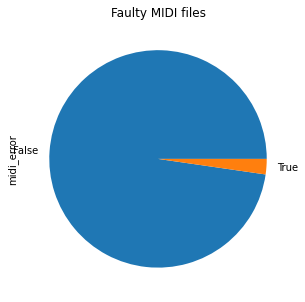

In [48]:
midi_df['midi_error'].value_counts().plot.pie()
plt.title('Faulty MIDI files');

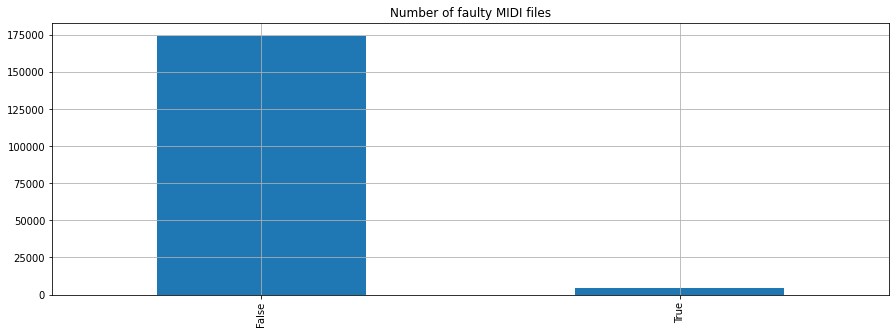

In [49]:
midi_df.midi_error.value_counts().plot.bar()
plt.title("Number of faulty MIDI files");

After we know the amount of failed MIDI files we could inspect those further to see if they are indeed corrupted or if our library has a bug.

In [50]:
midi_df[midi_df['midi_error'] == True]

,midi_path,midi_error,estimate_tempo,tempi_sec,tempi,end_time,drums,resolution,instrument_names,num_time_signature_changes,proto_path,original_files
3,../datasets/lmd/lmd_full/9/911cd08fa1fae36e5e0...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[s/sou.mid, S/sou.mid]"
24,../datasets/lmd/lmd_full/9/94862530febd2b295b9...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[e/ELVIS_PRESLEY__Dont_Be_Cruel.mid, ElvisPres..."
25,../datasets/lmd/lmd_full/9/906e72809900e01f919...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[dream theater/uagm1.mid]
98,../datasets/lmd/lmd_full/9/99e40264f321a4bfc5d...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[V/vong_tay_cau_hon.mid]
106,../datasets/lmd/lmd_full/9/9f22ccab9572cafafce...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[W/Wippenberg - Pong (Tocadisco Remix).mid, W/..."
...,...,...,...,...,...,...,...,...,...,...,...,...
178315,../datasets/lmd/lmd_full/5/5063a2b400597a372e7...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[f/faded.mid, 2009 MIDI/faded_love1-D120patsy_..."
178377,../datasets/lmd/lmd_full/5/523ce5adc656c872a69...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[l/laputa.mid, L/laputa.mid]"
178419,../datasets/lmd/lmd_full/5/546df09d78a32141369...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[h/heraldic.mid, H/heraldic.mid]"
178484,../datasets/lmd/lmd_full/5/5a4e49112c6cf832341...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[w/WESTERN.MID, 2009 MIDI/good_bad_and_ugly4-C..."


For now we will simply ignore those files and focus on the ones that we could sucessfully parse.

For our experiments it is important that the MIDI files contain a drum track - only the files we could succssfully parse and contain a drum track can be used for training of our model.

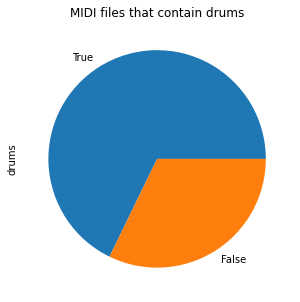

In [51]:
midi_df.drums.value_counts().plot.pie()
plt.title("MIDI files that contain drums");

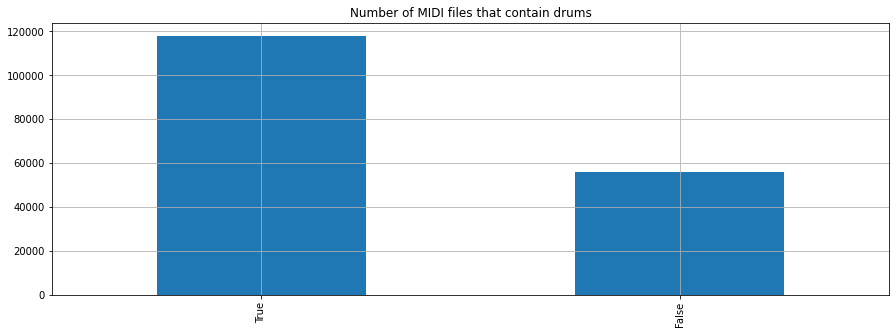

In [52]:
midi_df.drums.value_counts().plot.bar();
plt.title("Number of MIDI files that contain drums");

We should verify that the files in which we did not detect any drums have indeed no drums by listening to a random subset of them.

In [53]:
midi_df[midi_df['drums']==False].sample(10)

,midi_path,midi_error,estimate_tempo,tempi_sec,tempi,end_time,drums,resolution,instrument_names,num_time_signature_changes,proto_path,original_files
170937,../datasets/lmd/lmd_full/5/5c7f00cfbfb1c7a4c8d...,False,219.517230,"[0.0, 216.0]","[80.0, 82.00003553334875]",422.539545,False,480.0,[Piano],1.0,../datasets/lmd/proto/5c7f00cfbfb1c7a4c8df5cc0...,"[C/Casablan.MID, C/CASABLAN.MID, C/CASABLAN.MID]"
173537,../datasets/lmd/lmd_full/5/5ccabab69a29eb49782...,False,134.749985,"[0.0, 0.4225350000000001, 2.9225340000000006, ...","[71.00003550001773, 72.0000288000115, 68.00007...",271.779287,False,192.0,"[Flute, Celeste, Harp, Vibes]",10.0,../datasets/lmd/proto/5ccabab69a29eb49782f7ac2...,"[A/AS_OP19.MID, A/AS_OP19.MID]"
160054,../datasets/lmd/lmd_full/2/248de65be7464e72e13...,False,288.075739,[0.0],[143.99988480009216],13.333344,False,96.0,[MIDI out],0.0,../datasets/lmd/proto/248de65be7464e72e13026ee...,[H/Heaven's Cry - I Dont Need This No More.mid...
104986,../datasets/lmd/lmd_full/d/d62040c47cc8ccc1256...,False,230.565249,"[0.0, 1.1940279999999999, 1.6062414999999999, ...","[201.00031155048293, 131.00007641671124, 18.00...",418.198189,False,240.0,[Diskant],1.0,../datasets/lmd/proto/d62040c47cc8ccc12566150b...,"[r/raffsonatacl.mid, R/raffsonatacl.mid]"
177415,../datasets/lmd/lmd_full/5/5d3a4dcffc36dc21507...,False,183.485497,"[0.0, 26.052641999999995, 26.252641999999994, ...","[75.99996960001218, 75.0, 73.99998273333736, 7...",355.954855,False,96.0,"[PRIMI MANDOLINI, SECONDI MANDOLINI, MANDOLE, ...",3.0,../datasets/lmd/proto/5d3a4dcffc36dc21507ef683...,"[p/primiracconti.mid, P/primiracconti.mid]"
25978,../datasets/lmd/lmd_full/7/7a6107b2ebe71033dd6...,False,133.333333,[0.0],[100.0],46.500000,False,120.0,"[, , , ]",1.0,../datasets/lmd/proto/7a6107b2ebe71033dd6d7a5b...,"[h/himno442.mid, H/himno442.mid]"
17961,../datasets/lmd/lmd_full/0/09634cc18ee4b3e3d8e...,False,224.868701,[0.0],[132.000132000132],198.167415,False,192.0,"[Clarinet, Trumpet, Tuba, Strings, Strings]",1.0,../datasets/lmd/proto/09634cc18ee4b3e3d8e84072...,"[a/Airship_Remix.mid, A/Airship_Remix.mid]"
34639,../datasets/lmd/lmd_full/6/603e957bc609b539948...,False,100.000000,"[0.0, 62.5, 65.5, 86.5, 91.5, 112.5, 113.5, 11...","[60.0, 30.0, 60.0, 30.0, 60.0, 30.0, 60.0, 30....",191.763885,False,96.0,"[Soprano, Alto, Tenor, Bass, Piano (hi), Piano...",5.0,../datasets/lmd/proto/603e957bc609b5399481f26f...,[bliss/ppb74mhamt.mid]
161340,../datasets/lmd/lmd_full/2/24c247fe99ec2cfb909...,False,141.750142,[0.0],[126.00012600012599],63.805492,False,240.0,"[Piano, Piano]",1.0,../datasets/lmd/proto/24c247fe99ec2cfb909c4aa4...,"[W/waltz_05.mid, brahms/waltz_05.mid]"
29071,../datasets/lmd/lmd_full/7/7d3cac11d3db19406bb...,False,106.219130,[0.0],[91.04496862742124],42.176960,False,96.0,"[, , , ]",1.0,../datasets/lmd/proto/7d3cac11d3db19406bb568a5...,"[Christian/Inmyhart.mid, Various Artists/inmyh..."


Lets take also a look at the other metadata we have extracted.

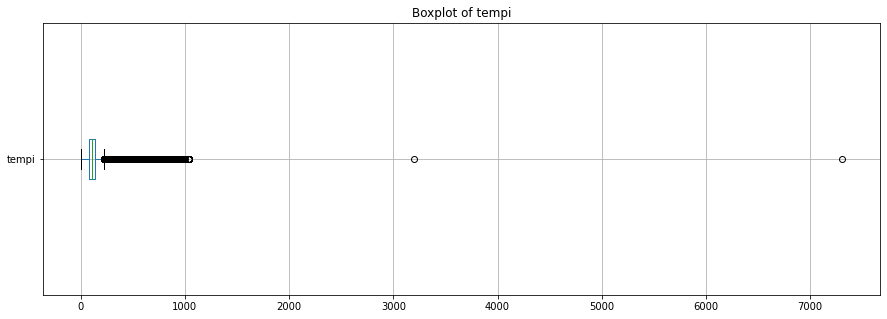

In [54]:
midi_df.explode('tempi')['tempi'].plot.box(vert=False);
plt.title('Boxplot of tempi');

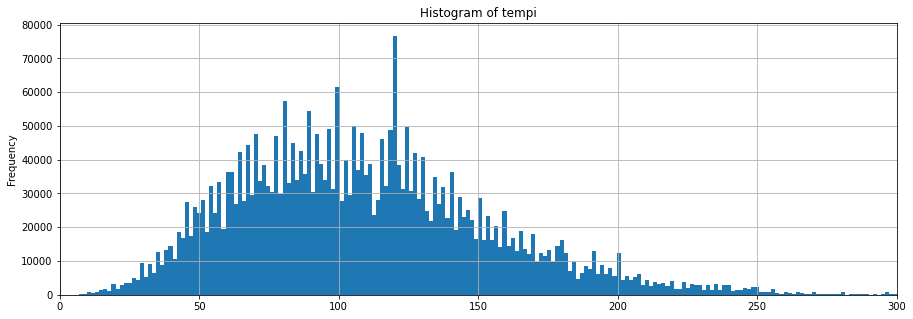

In [55]:
midi_df.explode('tempi')['tempi'].plot.hist(bins=5000, xlim=(0, 300));
plt.title('Histogram of tempi');

We notice a big spork at around 120 bpm which is rather interesting and should be inspected what the exact casue of this spike is.

It is important to have an understanding and feeling for the data.
We have an expectation of our data which can help us to see if the data makes sense and if we parsed it correctly but can also always be problematic because we project certain expectations on an projection and simplification of our data.

We can also count the occurences of tempi changes on songs.

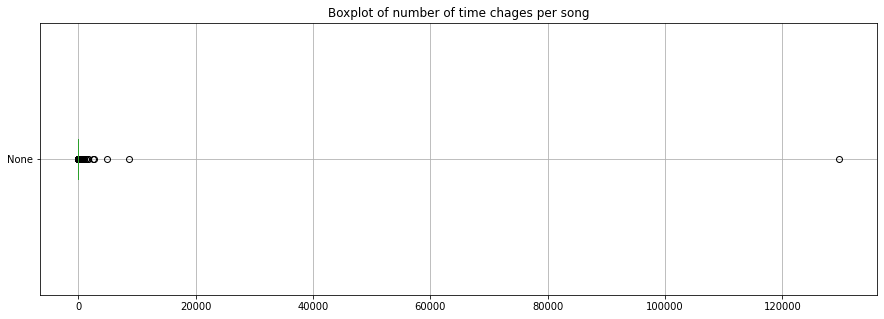

In [39]:
midi_df.explode('tempi').groupby('midi_path').size().value_counts().plot.box(vert=False);
plt.title('Boxplot of number of time chages per song');

In [40]:
midi_df.explode('tempi').groupby('midi_path').size().sort_values(ascending=False).head(10)

midi_path
../datasets/lmd/lmd_full/9/95cf26881a51f376a54e4e3f049f2d48.mid    6597
../datasets/lmd/lmd_full/3/34c04cd56b1087851f79780360f48225.mid    6096
../datasets/lmd/lmd_full/2/2677cf785791e1cfca13a0566aafbc85.mid    6096
../datasets/lmd/lmd_full/3/34a3df2a3a1e2267cf63657984f608cf.mid    5912
../datasets/lmd/lmd_full/c/c615436a609bf4e82c102503ea01d855.mid    5758
../datasets/lmd/lmd_full/1/1e40fd0edc293c8733a9c1b66517890b.mid    5758
../datasets/lmd/lmd_full/6/6662d98153d0c84d93e794d0c2b3940f.mid    5758
../datasets/lmd/lmd_full/8/8d956a0e5ee409a19adda9db287f7108.mid    4301
../datasets/lmd/lmd_full/0/001549d8bc6ba6dc62ade443cf01a51e.mid    4058
../datasets/lmd/lmd_full/0/0b0fdfe28eb0318ea3ac86046053724b.mid    3922
dtype: int64

Its worth to inspect those files in e.g. [MuseScore](https://musescore.org/de) and try to figure out what exactly happens in thos files.

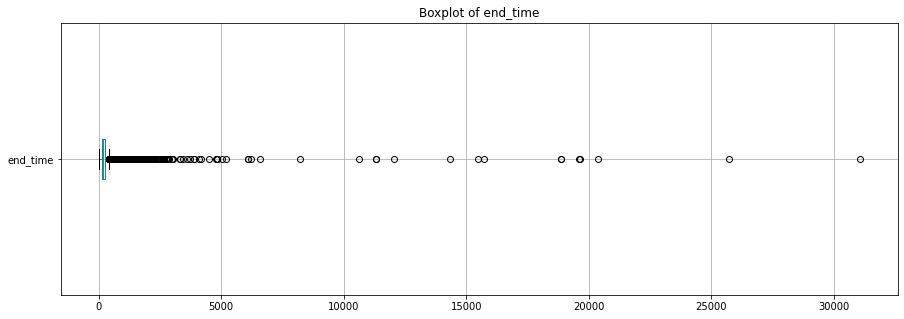

In [41]:
midi_df['end_time'].plot.box(vert=False);
plt.title('Boxplot of end_time');

We see that the `end_time` has some extreme values that are probably wrong - lets inspect those examples closer to see if we can see a pattern.

In [42]:
midi_df.sort_values('end_time', ascending=False).head(5)

,midi_path,midi_error,estimate_tempo,tempi_sec,tempi,end_time,drums,resolution,instrument_names,num_time_signature_changes,proto_path,original_files
84737,../datasets/lmd/lmd_full/f/f7b41341a20201f860c...,False,225.041860,[0.0],[128.0],31055.625000,False,120.0,"[Melody, On the Sun Road, Vivian Lai, Joseph L...",2.0,../datasets/lmd/proto/f7b41341a20201f860cb375e...,"[s/sunroad.mid, S/sunroad.mid]"
28204,../datasets/lmd/lmd_full/7/7abab3566b77073f827...,False,220.109820,"[0.0, 1.411764, 67.095876, 129.0154569375, 129...","[170.0000850000425, 95.00014250021376, 70.0000...",25714.187790,True,96.0,"[, , , , , , , ]",9.0,../datasets/lmd/proto/7abab3566b77073f8274c097...,[FErnszt/Olala.mid]
69901,../datasets/lmd/lmd_full/a/af6b689cfbb13c302bd...,False,229.041171,"[0.0, 5.052624, 40.420992, 94.420992, 118.4209...","[95.00014250021376, 190.0002850004275, 80.0, 1...",20384.791244,True,96.0,"[Acoustic Bass, Brass, Grand piano, Rock Organ...",7.0,../datasets/lmd/proto/af6b689cfbb13c302bd41b86...,[FErnszt/Swingin.mid]
26973,../datasets/lmd/lmd_full/7/73f4f536d3d42293bd7...,False,144.311366,[0.0],[122.00006913337249],19652.447880,True,192.0,"[tk1, tk2, tk3, tk4, tk10, tk11]",1.0,../datasets/lmd/proto/73f4f536d3d42293bd789b34...,"[Clapton Eric/Bellbottom Blues.mid, Various Ar..."
24515,../datasets/lmd/lmd_full/7/7486b07d9a4060fa614...,False,181.059483,"[0.0, 0.4829544166666666, 1.9996389166666664, ...","[88.00002346667293, 89.00994241056726, 90.0099...",19623.803343,True,192.0,"[Steel Str.Guitar, Fretless Bass, Piano, Violi...",13.0,../datasets/lmd/proto/7486b07d9a4060fa6142ac46...,[K/Kevin Parent Les Doigts 2.mid]


Regarding this it seems we should filter out those really long pieces as those are most probably wrong files.

Those errors could be caused by our parsing or by the MIDI files itself - but as we have a big enough corpora it is justifiable by not including those outliers.

Resolution corresponds to the [PPQN](https://en.wikipedia.org/wiki/Pulses_per_quarter_note) of the MIDI file.
Everything above 1000 should be suspicious, so lets take a look at those examples.

In [43]:
midi_df.sort_values('resolution', ascending=False).head(5)

,midi_path,midi_error,estimate_tempo,tempi_sec,tempi,end_time,drums,resolution,instrument_names,num_time_signature_changes,proto_path,original_files
33871,../datasets/lmd/lmd_full/6/610987ebaf0a326db40...,False,239.221606,[0.0],[120.0],135.368840,False,25000.0,"[, , , ]",1.0,../datasets/lmd/proto/610987ebaf0a326db4089867...,"[b/beethovenalladanza.mid, B/beethovenalladanz..."
45187,../datasets/lmd/lmd_full/1/1283eddbc4ab9042dcc...,False,225.608072,[0.0],[112.00005973336519],79.280092,True,24576.0,"[, , ]",1.0,../datasets/lmd/proto/1283eddbc4ab9042dccaea09...,"[Pop_and_Top40/2 Pac - Changes.mid, Pop_and_To..."
67351,../datasets/lmd/lmd_full/a/a5c6eb45c94d84474cb...,False,235.213491,[0.0],[120.0],26.987488,False,16384.0,"[, , ]",2.0,../datasets/lmd/proto/a5c6eb45c94d84474cbe00a3...,"[a/amigo3.mid, A/amigo3.mid]"
159033,../datasets/lmd/lmd_full/2/2076f0fa330be484c1c...,False,236.923314,[0.0],[140.00014000014],26.999973,False,15360.0,[Main Lead],1.0,../datasets/lmd/proto/2076f0fa330be484c1c60242...,"[M/M.I.D.O.R. - Far East.mid, M/m.i.d.o.r.__fa..."
15472,../datasets/lmd/lmd_full/0/0c3f038f4eaed7d7f8c...,False,272.000290,[0.0],[136.0001450668214],28.014676,False,15360.0,[Melody],1.0,../datasets/lmd/proto/0c3f038f4eaed7d7f8c90478...,"[W/whiteroom__someday_intro__ambia.mid, W/Whit..."


Another important metric is the number of time signatures.

If we use a step-sequencer like approach for our data we will need our data to have exactly one time signature.

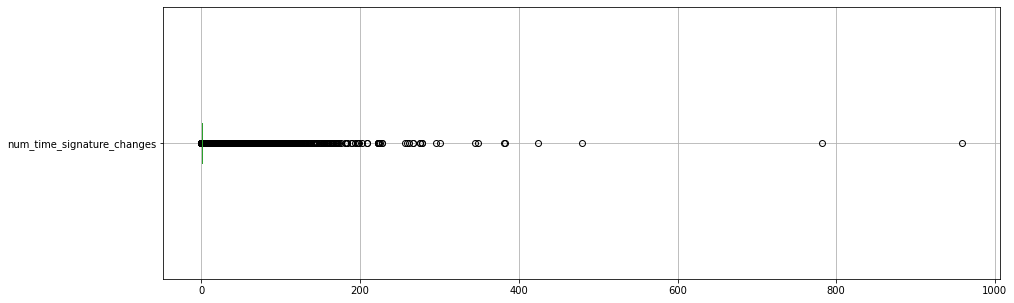

In [44]:
midi_df['num_time_signature_changes'].plot.box(vert=False);

In [45]:
midi_df.sort_values('num_time_signature_changes', ascending=False).head(5)

,midi_path,midi_error,estimate_tempo,tempi_sec,tempi,end_time,drums,resolution,instrument_names,num_time_signature_changes,proto_path,original_files
72284,../datasets/lmd/lmd_full/a/a85612fb0992100bded...,False,222.143725,"[0.0, 1.54624, 1.6513706666666668, 1.779370666...","[194.0190397350993, 190.23944805194805, 195.31...",204.310165,True,48.0,"[STRAUSS, STRAUSS, STRAUSS, STRAUSS, STRAUSS, ...",959.0,../datasets/lmd/proto/a85612fb0992100bded76798...,"[S/STRAUSS.MID, S/STRAUSS.MID]"
26776,../datasets/lmd/lmd_full/7/7d42a95293cc47bcacf...,False,199.481296,"[0.0, 1.6240640000000002, 2.071552, 2.22173866...","[160.0922131147541, 134.08180778032036, 133.16...",229.441685,True,48.0,"[NACHT, NACHT, NACHT, NACHT, NACHT, NACHT, NACHT]",782.0,../datasets/lmd/proto/7d42a95293cc47bcacfaa568...,[Hollands/NACHT.MID]
168045,../datasets/lmd/lmd_full/5/5693291bc82548fea37...,False,242.258977,[0.0],[136.0001450668214],255.266272,True,96.0,"[VIBRA SLAP, VIBRA SLAP, VIBRA SLAP, VIBRA SLA...",479.0,../datasets/lmd/proto/5693291bc82548fea376ec42...,"[S/Striving.MID, Midis Diversas/STRIVING.MID, ..."
60293,../datasets/lmd/lmd_full/8/85b2d4e8637008f6b4e...,False,218.486679,"[0.0, 2.5, 73.5, 75.586952, 89.884816, 131.884...","[96.0, 240.0, 230.00049833441304, 235.00013708...",283.476487,False,1024.0,"[, ]",424.0,../datasets/lmd/proto/85b2d4e8637008f6b4e54e5c...,[B/beevar2.mid]
44034,../datasets/lmd/lmd_full/6/69df67cd25dd33c1217...,False,228.828269,"[0.0, 1.25, 3.65, 102.78041, 105.1804100000000...","[96.0, 100.0, 115.0000287500072, 100.0, 115.00...",407.079384,False,1024.0,"[, ]",382.0,../datasets/lmd/proto/69df67cd25dd33c12177e159...,"[Schumann/Schuman Toccata op7.mid, Schumann/Sc..."


Lets check the amount of files we would loose if we limit our files to exactly one time signature.

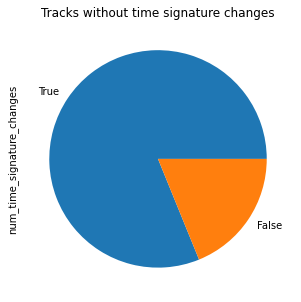

In [46]:
(midi_df.num_time_signature_changes <= 1).value_counts().plot.pie();
plt.title('Tracks without time signature changes');

We can also take a look at the most common instrument names in our dataset.

In [47]:
midi_df.explode('instrument_names').instrument_names.value_counts().head(20)

                  354676
Bass               29532
Drums              19438
untitled           18471
Piano              16344
Strings            10922
Soprano            10478
Guitar             10126
Alto                9368
Tenor               8987
DRUMS               8013
Melody              6693
WinJammer Demo      6488
Voice               6270
Piano (hi)          4905
Piano (lo)          4900
Italian             4679
STRINGS             4003
bass                3785
MELODY              3775
Name: instrument_names, dtype: int64

And also take a look at the most common names of our original filenames.

In [48]:
midi_df.explode('original_files').original_files.str.replace('[^a-zA-Z]', ' ').str.lower().str.split(' ').explode().value_counts().head(50)

<ipython-input-48-4f9f4be492b3>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  midi_df.explode('original_files').original_files.str.replace('[^a-zA-Z]', ' ').str.lower().str.split(' ').explode().value_counts().head(50)


              1091324
mid            570786
midi            56765
various         42479
artists         36610
a               34883
the             34148
l               29181
s               28479
polyphone       24771
sure            23089
i               22765
m               20958
e               20792
t               19164
midis           19014
c               18162
b               17950
d               17712
n               17012
h               15452
o               15425
g               13303
you             13228
p               12267
k               12032
of              11890
poly            11836
in              11073
f               10433
beatles          9696
love             9246
r                8911
me               8901
j                8816
diversen         8643
my               8172
to               7585
divers           7025
w                6894
analisadas       6320
no               6073
de               5601
on               5373
and              5349
midirip   

An interesting aspect of this analyis reveals that the most common words in a text corpora do not often contain much information what the text is about because the grammar structure of the text introduces noise to the dataset.

There are basic algorithms such as [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) which allows us to filter out the noise by asserting that a word which is common in many documents has little to no meaning (e.g. *the* or in our case *midi*) and therefore give it a low score.
Although if a significant subset of our file names contain a word that is not so common in the other file names (e.g. *beatles*) this *token* will receive a high rating.

For now we dont want to inspect this further but its always good to know such kind of algorithms as it helps to filter out the relevant data.

Its also good to make some sanity checks on our data.
One assumption would be that every file in which we did not detect a drum track also does not contain an instrument with the name *drums*.

In [49]:
explodeded_df = midi_df.explode('instrument_names')
explodeded_df[
    (explodeded_df['instrument_names'].str.lower().isin(['drums', 'drum']))&
    (explodeded_df['drums'] == False)
].groupby('midi_path').first().reset_index()

,midi_path,midi_error,estimate_tempo,tempi_sec,tempi,end_time,drums,resolution,instrument_names,num_time_signature_changes,proto_path,original_files
0,../datasets/lmd/lmd_full/0/0093ffc81428aabfa14...,False,190.000285,[0.0],[190.0002850004275],137.151110,False,192.0,Drums,1.0,../datasets/lmd/proto/0093ffc81428aabfa14aaa13...,"[M/Martha My Dear 3.mid, Beatles +GeorgeJohnPa..."
1,../datasets/lmd/lmd_full/0/032e298d9560fdbe954...,False,120.000180,[0.0],[190.0002850004275],114.947196,False,120.0,Drums,1.0,../datasets/lmd/proto/032e298d9560fdbe954d7551...,"[s/smetmoth.mid, S/smetmoth.mid]"
2,../datasets/lmd/lmd_full/0/043e1c01e58a4bb4499...,False,139.999977,"[0.0, 0.4285715, 7.071422000000001, 39.071422]","[69.99998833333528, 140.00014000014, 60.0, 69....",196.778591,False,120.0,Drums,1.0,../datasets/lmd/proto/043e1c01e58a4bb44995ee38...,[Songs+300/Tunnel_o.mid]
3,../datasets/lmd/lmd_full/0/06f86377b1dbad0ebf0...,False,226.482465,"[0.0, 1.0, 15.608691999999998]","[120.0, 115.0000287500072, 120.0]",59.483692,False,192.0,DRUMS,1.0,../datasets/lmd/proto/06f86377b1dbad0ebf08fdcd...,"[s/seaquest2.mid, S/seaquest2.mid]"
4,../datasets/lmd/lmd_full/0/078e2cc7c46eb5de726...,False,204.052854,[0.0],[98.00014373354414],281.211322,False,192.0,Drums,1.0,../datasets/lmd/proto/078e2cc7c46eb5de72621329...,"[Pop/SLEGDEHM.MID, PeterGabriel/Sledgehammer6...."
...,...,...,...,...,...,...,...,...,...,...,...,...
148,../datasets/lmd/lmd_full/f/f2a97c0f7fa26244a77...,False,218.459582,[0.0],[70.00007000007],213.553358,False,192.0,drums,1.0,../datasets/lmd/proto/f2a97c0f7fa26244a77a8d0f...,"[u/unchainedmelody3.mid, U/UnchainedMelody3.mid]"
149,../datasets/lmd/lmd_full/f/f6702b2445a6ce9aa8e...,False,211.143695,[0.0],[120.0],21.241667,False,480.0,Drums,1.0,../datasets/lmd/proto/f6702b2445a6ce9aa8e6cad8...,"[e/ElectroJam.Mid, E/ElectroJam.Mid]"
150,../datasets/lmd/lmd_full/f/f8a56c3ebc00bfef70d...,False,157.793103,[0.0],[80.0],263.847656,False,192.0,Drums,1.0,../datasets/lmd/proto/f8a56c3ebc00bfef70d033a8...,"[t/tearinhand.mid, T/tearinhand.mid]"
151,../datasets/lmd/lmd_full/f/fa06799e6825c6a4095...,False,284.928064,[0.0],[148.99983858350816],383.315852,False,240.0,drums,16.0,../datasets/lmd/proto/fa06799e6825c6a4095e2934...,"[l/louder.mid, L/louder.mid]"


Listening to those examples reveal that some of them use another instrument than drums for their drums - either by artistic choice or by mistake.
As this *only* applies to 153 files we can live with this error and ignore the files were we did not detect the drum track.

## Filter and extract the data

After inspecting all availabe files we should filter out some *noisy* files that are either not interesting to us (they lack a drum track) or the parsing of the MIDI files did not work as expected.
With the analysis above we can verify borders of data we want to allow.


In [50]:
filtered_midi_df = midi_df[
    (midi_df.drums == True)
    & (midi_df.midi_error == False)
    & (midi_df.end_time.between(30, 800))
    & (midi_df.num_time_signature_changes<=1)
]
filtered_midi_df

,midi_path,midi_error,estimate_tempo,tempi_sec,tempi,end_time,drums,resolution,instrument_names,num_time_signature_changes,proto_path,original_files
5,../datasets/lmd/lmd_full/9/9d30679480d0e55a07b...,False,224.502048,[0.0],[115.00002875000717],296.347752,True,120.0,"[Piano, Organ, Big Brass, Horns, Horns2, Horns...",1.0,../datasets/lmd/proto/9d30679480d0e55a07be1414...,[S/Smooth .mid]
9,../datasets/lmd/lmd_full/9/974f5b2466a5d5670df...,False,184.213982,"[0.0, 2.714283, 170.86248999999998, 171.960050...","[210.00021000021, 80.99997165000993, 82.000035...",225.896259,True,120.0,"[, , , , , , , , , ]",1.0,../datasets/lmd/proto/974f5b2466a5d5670dfddee0...,"[Sure.Polyphone.Midi/A Winter's Tale.mid, w/wi..."
10,../datasets/lmd/lmd_full/9/952df587b9fff5adbeb...,False,265.636110,[0.0],[144.0023040368646],216.460946,True,480.0,"[Track 2, Track 3, Track 4, Track 5, Track 6, ...",1.0,../datasets/lmd/proto/952df587b9fff5adbeb5f40b...,"[E/Enola Gay 63.mid, divers midi 3/OMD_-_Enola..."
11,../datasets/lmd/lmd_full/9/93e2cb3a0c36af361bb...,False,165.000165,[0.0],[165.000165000165],310.029993,True,480.0,"[Chorus Guitar, Overdrive Guita, Overdrive Gui...",1.0,../datasets/lmd/proto/93e2cb3a0c36af361bb49c5e...,"[z/zombie05.mid, Z/zombie05.mid]"
12,../datasets/lmd/lmd_full/9/97c1f795ffb676dfaa5...,False,212.877687,[0.0],[110.00011000011],222.766823,True,192.0,"[BASS, E.PIANO, GUITAR, STRINGS, PIANO, New Tr...",1.0,../datasets/lmd/proto/97c1f795ffb676dfaa5a0202...,"[J/J. Rivers Poor Side of Town.mid, divers mid..."
...,...,...,...,...,...,...,...,...,...,...,...,...
178555,../datasets/lmd/lmd_full/5/5bd52f314b616bf50c4...,False,141.332152,"[0.0, 183.428388, 186.85695800000002, 241.9283...","[70.00007000007, 35.00001458333941, 70.0000700...",250.221166,True,480.0,"[Track 1, Track 2, Track 3, Track 4, Track 6, ...",1.0,../datasets/lmd/proto/5bd52f314b616bf50c40104c...,[T/taylor_swift-tim_mcgraw.mid]
178556,../datasets/lmd/lmd_full/5/5eea68ee369af3ee5cc...,False,184.252715,"[0.0, 210.73867815, 210.75516165, 210.77763355...","[90.00009000009, 91.00009100009099, 89.0000400...",299.296908,True,240.0,"[You've Made Me So Very Happy, You've Made Me ...",1.0,../datasets/lmd/proto/5eea68ee369af3ee5cc577ba...,"[Y/Youvemad L.mid, Y/YOUVEMAD L.mid, Y/YOUVEMA..."
178557,../datasets/lmd/lmd_full/5/5309fb3f62bf73780e6...,False,183.172080,[0.0],[81.01003309259853],139.390142,True,120.0,"[, , , , , , , , , ]",1.0,../datasets/lmd/proto/5309fb3f62bf73780e61f85b...,"[R/Roberto Carlos - Propuesta L.mid, Midis Jov..."
178559,../datasets/lmd/lmd_full/5/5538b0174111bcef760...,False,274.353398,[0.0],[142.00007100003546],172.389879,True,96.0,"[Std Drums, Jazz Gtr, Muted Gtr (Lead Dbl), Mu...",1.0,../datasets/lmd/proto/5538b0174111bcef760a5f29...,"[B/Boys 2.mid, b/boys_2.mid, Beatles +GeorgeJo..."


In [51]:
len(filtered_midi_df)/len(midi_df)

0.5479696014247232

We now filtered half of our available examples by just looking at the metadata of the MIDI files.
The next step is to transform the drum track of each MIDI file into a mathematical representation. 

The notatation within the MIDI file is bound to a strictly timely manner but in music we often put the timely domain in relation to a tempo which remaps the time measured in seconds.
A common unit for this is *beats per minute* (bpm) where 60 bpm maps each second to a *beat* - if we want to shorten the time between two beats (commonly refered to as *faster*) we increase the *bpm* and vice versa.

Another instance for the segmentation of events in time is the *time signature* of a track.

One notation which tries to simplify this notation is in the form of a *step seqencer* in which we snap notes to the nearest step on a grid

For this we can use *note_seq* with the function [midi_file_to_drum_track](https://github.com/magenta/note-seq/blob/6631a4299092cd52201e2f4a8e36c1223d76561f/note_seq/drums_lib.py#L269).

## Conclusion

We filtered out all noisy examples of our dataset and transformed the drum track into a mathematical, simplified notation.

In the next step we will start to analyse the drum patterns that we extracted.